In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import warnings
import shap
import pickle
from contextlib import contextmanager

import mlflow
import mlflow.sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from evidently.report import Report
from evidently.metrics import DataDriftTable, DatasetDriftMetric
import warnings
warnings.filterwarnings('ignore')


In [3]:
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

In [5]:
train_df= pd.read_csv('train_df.csv')

In [6]:
# Vérification si le DataFrame contient des valeurs nulles
if train_df.isnull().any().any():
    print("Le DataFrame contient des valeurs nulles.")
else:
    print("Le DataFrame ne contient pas de valeurs nulles.")


Le DataFrame ne contient pas de valeurs nulles.


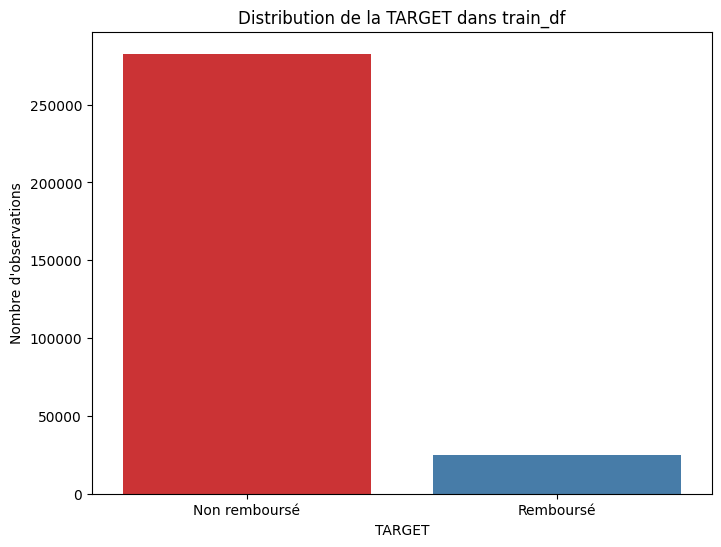

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=train_df, palette='Set1')
plt.xlabel('TARGET')
plt.ylabel('Nombre d\'observations')
plt.title('Distribution de la TARGET dans train_df')
plt.xticks([0, 1], ['Non remboursé', 'Remboursé'])
plt.show()


In [8]:
 train_df2= train_df.drop(columns=['SK_ID_CURR'])

In [9]:
X = train_df2.drop(columns=['TARGET'])
y = train_df2['TARGET'].astype(int)

# Division du dataframe en ensembles d'entraînement et de validation


X_val, X_val_test, y_val, y_val_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)

print(X_val_test.shape, y_val_test.shape)
print(X_val.shape, y_val.shape)

(61502, 183) (61502,)
(246005, 183) (246005,)


Nous créons les fonctions que nous utiliserons dans la suite de la modélisation. Ces fonctions permettent notamment de calculer certaines métriques et graphes à des fins de comparaison des performances de nos modèles.

Nous crééons une métrique personnalisée ayant une approche métier. Le but ici est de pénaliser plus fortement les faux négatifs (mauvais client prédit bon client) qui engendrent une grande perte de capital. On suppose ici que le coût d’un FN (Faux Négatif) est dix fois supérieur au coût d’un FP (Faux Positif).

Nous calculerons également d'autres métriques telles que :

    Accuracy: somme de tous les vrais positifs et vrais négatifs qu'il divise par le nombre total d'instances. Il permet d'apporter une réponse à la question suivante : de toutes les classes positives et négatives, combien parmi elles ont été prédites correctement ? Des valeurs élevées de ce paramètre sont souvent souhaitables.
    
    Precision: indique le rapport entre les prévisions positives correctes et le nombre total de prévisions positives. Ce paramètre répond donc à la question suivante : sur tous les enregistrements positifs prédits, combien sont réellement positifs ?
    
    Recall/Rappel : paramètre qui permet de mesurer le nombre de prévisions positives correctes sur le nombre total de données positives. Il permet de répondre à la question suivante : sur tous les enregistrements positifs, combien ont été correctement prédits ? La mesure vise à minimiser les faux négatifs.
    
    F1 score : moyenne harmonique de la précision et du rappel. Il équivaut au double du produit de ces deux paramètres sur leur somme. Sa valeur est maximale lorsque le rappel et la précision sont équivalents. Il est particulièrement difficile de comparer deux modèles avec une faible précision et un rappel élevé. Le contraire est également vérifié. Dans ces conditions, le score F1 permet de mesurer ces deux paramètres simultanément.
    
    Fbeta score : généralisation de la F-measure qui ajoute un paramètre de configuration appelé beta. Une valeur bêta par défaut est 1.0, ce qui est identique à la mesure F. Une valeur bêta plus petite, telle que 0.5, donne plus de poids à la précision et moins au rappel, tandis qu'une valeur bêta plus grande, telle que 2.0, donne moins de poids à la précision et plus de poids au rappel dans le calcul du score. Ici nous donnons plus de poids au rappel qui minimise les faux négatifs.
    
    ROC AUC score : mesure de façon globale la performance d’un modèle de classification. Il indique à quel point le modèle est capable de faire la distinction entre les classes. Il est égal à 1 pour un modèle parfait et à 0.5 pour un modèle non-informatif.



In [10]:
def fonction_metier(y_true, y_pred):
    '''Créer un score métier à partir de la matrice de confusion.
    :param: y_true (vraies valeurs), y_pred (valeurs prédites par le modèle)
    :return: gain (score métier)
    '''
    TP_coeff = 0       # Vrais positifs
    FP_coeff = 0       # Faux positifs (prédit comme faisant défaut (1) mais ne fait pas défaut (0))
    FN_coeff = -10     # Faux négatifs (prédit comme ne faisant pas défaut (0) mais font défaut (1))
    TN_coeff = 1       # Vrais négatifs
    
    (TN, FP, FN, TP) = metrics.confusion_matrix(y_true, y_pred).ravel()
    
    gain = (TP*TP_coeff + TN*TN_coeff + FP*FP_coeff + FN*FN_coeff)/(TN+FP+FN+TP)
    
    return gain

def score_metier_max(y_pred_proba, y_true, verbose=True):
    '''Créer un graphique permettant de déterminer quel peut être le score max en fonction du threshold.
    :param: y_pred_proba (probabilités prédites par le modèle), y_true (vraies valeurs),
    verbose (affiche le graphe ou juste le score maximal)
    :return: graphique, 
    '''
    scores = []
    for threshold in np.linspace(0, 1, num=101):
        y_pred = np.where(y_pred_proba > threshold, 1, 0)
        score = fonction_metier(y_true, y_pred)
        scores.append(score)

    if verbose == True:
        score_max = max(scores)
        opti_threshold = np.linspace(0, 1, num=101)[scores.index(score_max)]
        y_pred = np.where(y_pred_proba > opti_threshold, 1, 0)
        
        print("Score métier maximum : {:.2f}".format(score_max))
        print("Threshold optimal : {}".format(opti_threshold))
        
        fig, ax = plt.subplots(figsize=(6, 5))
        plt.plot(np.linspace(0, 1, num=101), scores, label="model score")
        plt.axvline(x=opti_threshold, color='k', dashes=(0.5, 1), 
                    label="optimal threshold: {}".format(opti_threshold))
        
        plt.title("Score métier en fonction du threshold", fontsize=10)
        plt.xlabel("Thresholds", fontsize=10)
        plt.ylabel("Score métier", fontsize=10)
        plt.legend()
        plt.show()
     
    else:
        return max(scores)

    
def conf_mat_transform(y_true, y_pred):
    '''Créer et affiche la matrice de confusion.
    :param: y_true (vraies valeurs), y_pred (valeurs prédites par le modèle)
    :return: affiche la matrice de confusion
    '''
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    plt.figure(figsize = (6,4))
    sns.heatmap(conf_mat, annot=True, cmap="Blues")
    
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Matrice de confusion')


def eval_score(model, X_val, y_true, seuil=0.5):
    '''Calcule, affiche et enregistre les différentes métriques.
    :param: model, X_val (dataframe de validation), y_true (vraies valeurs),
    seuil (seuil de détermination des prédictions)
    :return: affiche (et return) les métriques, la matrice de confusion et la courbe ROC.
    '''    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred = np.where(y_pred_proba > seuil, 1, 0)
    
    metier = fonction_metier(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    fbeta_score = metrics.fbeta_score(y_true, y_pred, beta=2)
    rocauc = metrics.roc_auc_score(y_true, y_pred)
    
    print('Score métier :{:.2f}'.format(metier))
    print('Accuracy score : {:.2f}'.format(accuracy))
    print('Precision score : {:.2f}'.format(precision))
    print('Recall score : {:.2f}'.format(recall))
    print('F1 score : {:.2f}'.format(f1_score))
    print('Fbeta score : {:.2f}'.format(fbeta_score))
    print('ROC AUC score : {:.2f}'.format(rocauc))
    
    
    conf_mat_transform(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred_proba)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Courbe ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba

 # Dummy Classifier

In [10]:
# Terminer le run actif s'il y en a un
if mlflow.active_run():
    mlflow.end_run()

2024/04/28 17:28:22 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Score métier :0.11
Accuracy score : 0.92
Precision score : 0.00
Recall score : 0.00
F1 score : 0.00
Fbeta score : 0.00
ROC AUC score : 0.50


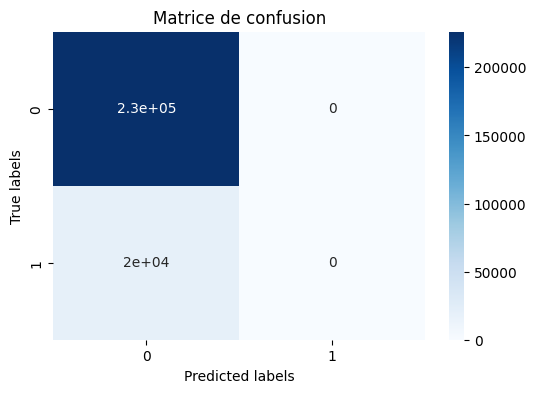

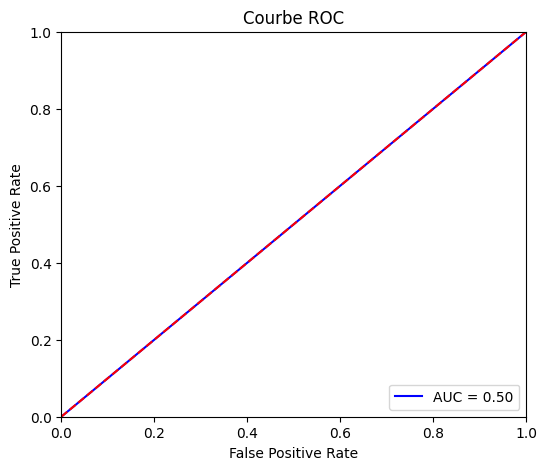

In [11]:
mlflow.set_experiment("DummyClassifier")
# Création d'un scorer object à partir de votre fonction de score personnalisée
score_metier_scorer = make_scorer(fonction_metier, greater_is_better=True)

# Définition de la pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=0)),
    ('scaler', StandardScaler()),
    ('classifier', DummyClassifier(random_state=0))
])

# Paramètres pour RandomizedSearchCV
parameters = {
    'classifier__strategy': ['stratified', 'most_frequent', 'prior', 'uniform']
}
# Création du RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters, n_iter=20, cv=5, scoring=score_metier_scorer, random_state=0)

# Entraînement avec RandomizedSearchCV
with mlflow.start_run(run_name='DummyClassifier avec SMOTE et StandardScaler'):
    random_search.fit(X_val, y_val)

    # Enregistrement des meilleurs paramètres et du meilleur score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    mlflow.log_params(best_params)
    mlflow.log_metric("best_score", best_score)

    # Calcul et enregistrement des métriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score = eval_score(random_search.best_estimator_, X_val, y_val)
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

    # Enregistrement du meilleur modèle
    mlflow.sklearn.log_model(random_search.best_estimator_, "best_model")


Score métier maximum : 0.11
Threshold optimal : 0.0


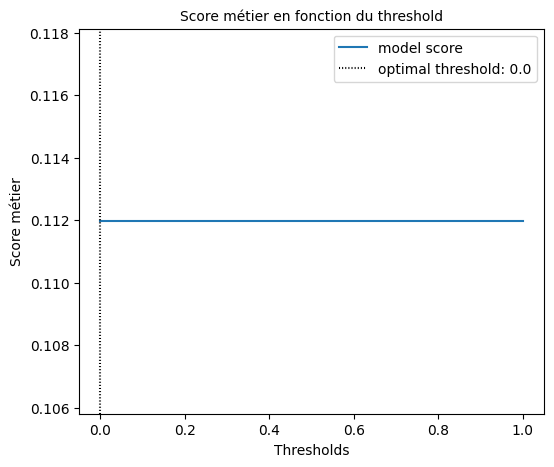

In [12]:
score_metier_max( y_pred_proba, y_val, verbose=True)

Grâce à la matrice de confusion, on constate que le Dummy Classifier prédit bien seulement la classe 0 (client ne faisant pas défaut) et contient donc beaucoup de faux négatifs (mauvais client prédit bon client). C'est la raison pour laquelle il possède un score métier relativement faible (car ce dernier pénalise plus fortement les faux négatifs).

La plupart de nos scores sont à 0 puisque le modèle ne prédit aucune valeur positive. Les scores sont donc estimés à 0 puisque cela engendre une division par 0.

On constate que l'AUC est de 0.5 comme c'est le cas pour les modèles baseline.


# regression logistic 

In [24]:
# Terminer le run actif s'il y en a un
if mlflow.active_run():
    mlflow.end_run()


In [25]:
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

Score métier :0.12
Accuracy score : 0.92
Precision score : 0.42
Recall score : 0.02
F1 score : 0.03
Fbeta score : 0.02
ROC AUC score : 0.51


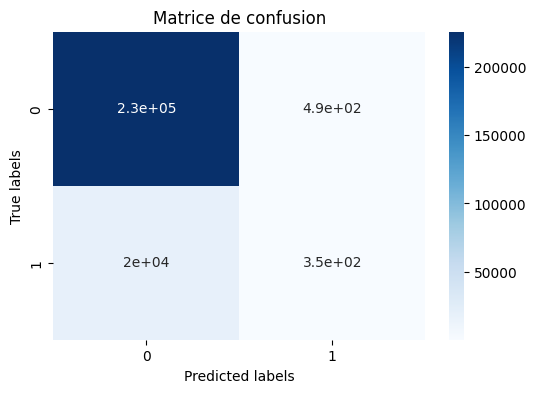

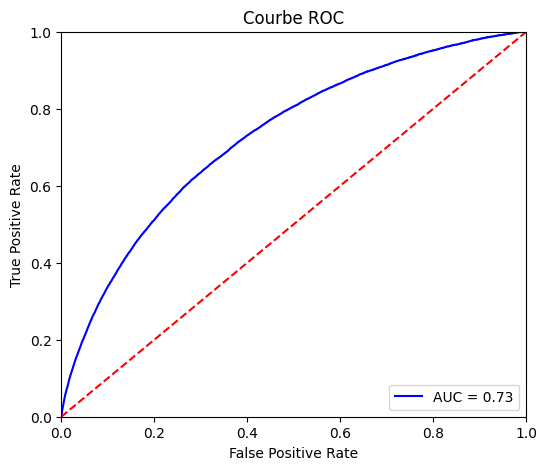

In [26]:
mlflow.set_experiment("Logistic Regression")
# Création d'un scorer object à partir de votre fonction de score personnalisée
score_metier_scorer = make_scorer(fonction_metier, greater_is_better=True)

# Définition de la pipeline avec régression logistique
pipeline = Pipeline([
    ('smote', SMOTE(random_state=0)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=0))
])

# Paramètres pour RandomizedSearchCV
parameters = {
    'classifier__C': np.logspace(-3, 3, 100),  # Exemple de plage pour la régularisation
    'classifier__solver': ['lbfgs', 'liblinear']  # Exemple de solveurs
}

# Création du RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters, n_iter=20, cv=5, scoring=score_metier_scorer, random_state=0)

# Entraînement avec RandomizedSearchCV
with mlflow.start_run(run_name='Logistic Regression avec SMOTE et StandardScaler'):
    random_search.fit(X_val, y_val)

    # Enregistrement des meilleurs paramètres et du meilleur score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    mlflow.log_params(best_params)
    mlflow.log_metric("best_score", best_score)

    # Calcul et enregistrement des métriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = eval_score(random_search.best_estimator_, X_val, y_val)

mlflow.log_metric("val_score_métier", score_metier)
mlflow.log_metric("val_accuracy", accuracy)
mlflow.log_metric("val_precision", precision)
mlflow.log_metric("val_recall", recall)
mlflow.log_metric("val_f1_score", f1_score)
mlflow.log_metric("val_fbeta_score", fbeta_score)
mlflow.log_metric("val_rocauc", rocauc)
    # Enregistrement du meilleur modèle
mlflow.sklearn.log_model(random_search.best_estimator_, "best_model")



In [27]:
 best_params 

{'classifier__solver': 'liblinear', 'classifier__C': 0.0013219411484660286}

Score métier maximum : 0.35
Threshold optimal : 0.1


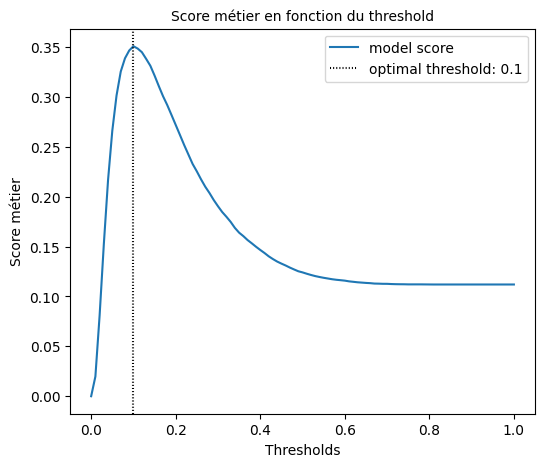

In [28]:
score_metier_max( y_pred_proba, y_val, verbose=True)

# RandomForestClassifier

In [29]:
# Terminer le run actif s'il y en a un
if mlflow.active_run():
    mlflow.end_run()


In [30]:
 mlflow.set_tracking_uri('http://127.0.0.1:5000/')

Score métier :0.19
Accuracy score : 0.87
Precision score : 0.19
Recall score : 0.17
F1 score : 0.18
Fbeta score : 0.18
ROC AUC score : 0.55


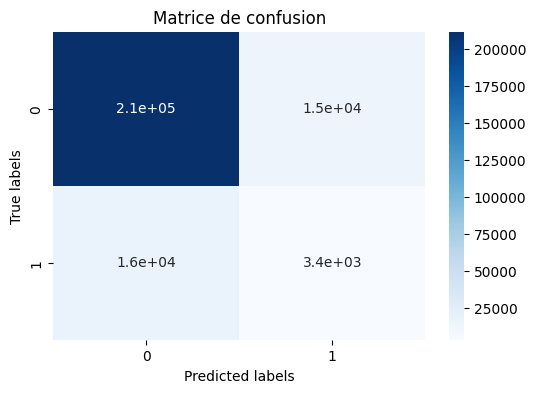

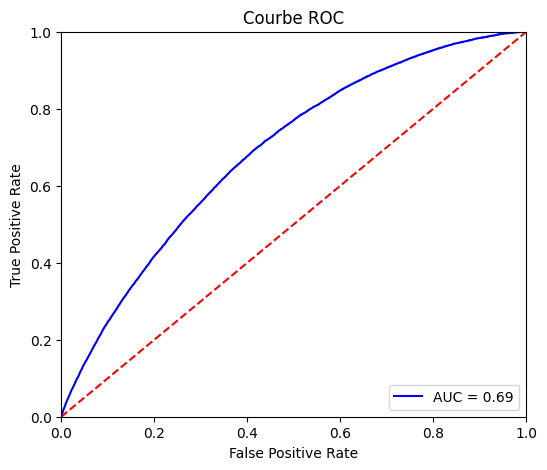

In [31]:
mlflow.set_experiment("RandomForestClassifier")

# Création d'un scorer object à partir de votre fonction de score personnalisée
score_metier_scorer = make_scorer(fonction_metier, greater_is_better=True)

# Définition de la pipeline avec régression logistique
pipeline = Pipeline([
    ('smote', SMOTE(random_state=0)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=0))
])

# Paramètres pour RandomizedSearchCV
parameters =  {
    'classifier__n_estimators': [100, 200, 300],  # Nombre d'arbres dans la forêt
    'classifier__max_depth': [None, 10, 20, 30],  # Profondeur maximale de chaque arbre
    'classifier__min_samples_split': [2, 5, 10],  # Nombre minimum d'échantillons requis pour diviser un nœud
    'classifier__min_samples_leaf': [1, 2, 4],  # Nombre minimum d'échantillons requis à chaque feuille
    'classifier__bootstrap': [True, False]  # Méthode de sélection des échantillons pour l'apprentissage de chaque arbre
}

# Création du RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters, n_iter=20, cv=5, scoring=score_metier_scorer, random_state=0)

# Entraînement avec RandomizedSearchCV et enregistrement des résultats avec MLflow
with mlflow.start_run(run_name='Random Forest avec SMOTE et StandardScaler'):
    # Entraînement avec RandomizedSearchCV
    random_search.fit(X_val, y_val)

    # Enregistrement des meilleurs paramètres et du meilleur score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    mlflow.log_params(best_params)
    mlflow.log_metric("best_score", best_score)

    # Calcul et enregistrement des métriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = eval_score(random_search.best_estimator_, X_val, y_val)

    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)
    
    # Enregistrement du meilleur modèle
    mlflow.sklearn.log_model(random_search.best_estimator_, "best_model")


In [32]:
 best_params 

{'classifier__n_estimators': 200,
 'classifier__min_samples_split': 2,
 'classifier__min_samples_leaf': 2,
 'classifier__max_depth': 10,
 'classifier__bootstrap': True}

Score métier maximum : 0.29
Threshold optimal : 0.3


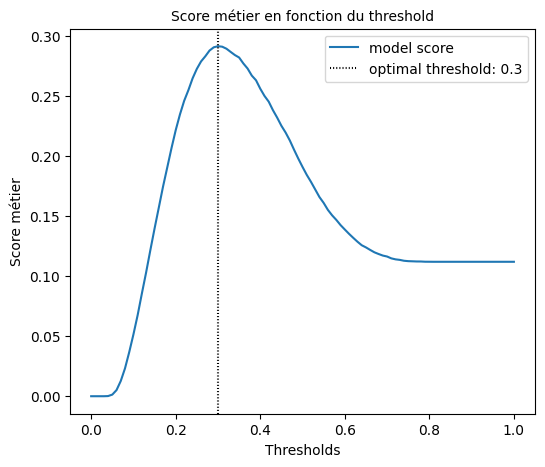

In [33]:
score_metier_max( y_pred_proba, y_val, verbose=True)

# XGBClassifier

In [34]:
# Terminer le run actif s'il y en a un
if mlflow.active_run():
    mlflow.end_run()


In [62]:
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

Score métier :0.23
Accuracy score : 0.69
Precision score : 0.13
Recall score : 0.48
F1 score : 0.20
Fbeta score : 0.31
ROC AUC score : 0.60


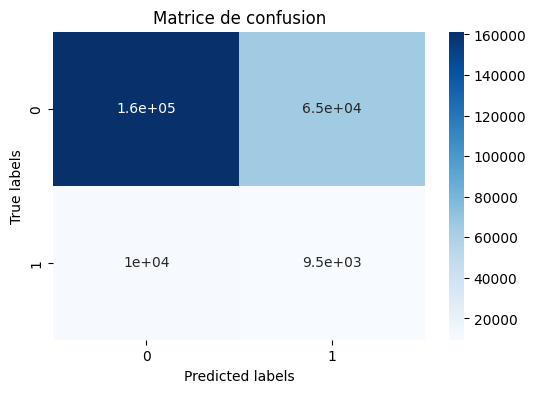

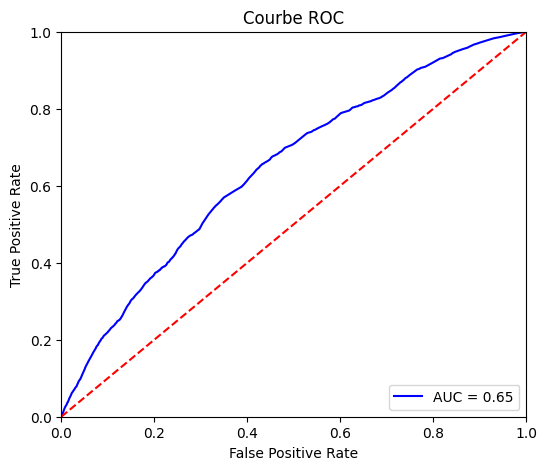

In [50]:
mlflow.set_experiment("XGBClassifier")
# Création d'un scorer object à partir de votre fonction de score personnalisée
score_metier_scorer = make_scorer(fonction_metier, greater_is_better=True)

# Définition de la pipeline avec régression logistique
pipeline = Pipeline([
    ('smote', SMOTE(random_state=0)),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(random_state=0))
])

# Paramètres pour RandomizedSearchCV
parameters =  {
    'classifier__n_estimators': [100, 200, 300],  # Nombre d'estimateurs
    'classifier__max_depth': [3, 4, 5],  # Profondeur maximale de chaque arbre
    'classifier__learning_rate': [0.1, 0.01, 0.001],  # Taux d'apprentissage
    'classifier__gamma': [0, 0.1, 0.2],  # Paramètre de régularisation gamma
    'classifier__subsample': [0.8, 0.9, 1.0],  # Sous-échantillonnage de l'ensemble de données
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],  # Sous-échantillonnage des colonnes lors de la construction de chaque arbre
}

# Création du RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters, n_iter=20, cv=5, scoring=score_metier_scorer, random_state=0)
# Entraînement avec RandomizedSearchCV
with mlflow.start_run(run_name='XGBClassifier avec SMOTE et StandardScaler'):
    random_search.fit(X_val, y_val)

    # Enregistrement des meilleurs paramètres et du meilleur score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    mlflow.log_params(best_params)
    mlflow.log_metric("best_score", best_score)

    # Calcul et enregistrement des métriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = eval_score(random_search.best_estimator_, X_val, y_val)

mlflow.log_metric("val_score_métier", score_metier)
mlflow.log_metric("val_accuracy", accuracy)
mlflow.log_metric("val_precision", precision)
mlflow.log_metric("val_recall", recall)
mlflow.log_metric("val_f1_score", f1_score)
mlflow.log_metric("val_fbeta_score", fbeta_score)
mlflow.log_metric("val_rocauc", rocauc)
    # Enregistrement du meilleur modèle
mlflow.sklearn.log_model(random_search.best_estimator_, "best_model")


In [52]:
 best_params 

{'classifier__subsample': 0.8,
 'classifier__n_estimators': 200,
 'classifier__max_depth': 3,
 'classifier__learning_rate': 0.001,
 'classifier__gamma': 0.2,
 'classifier__colsample_bytree': 0.9}

Score métier maximum : 0.25
Threshold optimal : 0.48


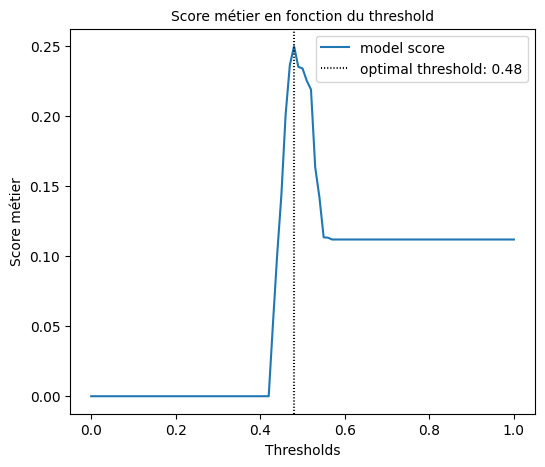

In [53]:
score_metier_max( y_pred_proba, y_val, verbose=True)

# lightgbm  (LGBMClassifier)

In [39]:
# Terminer le run actif s'il y en a un
if mlflow.active_run():
    mlflow.end_run()


In [40]:
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

[LightGBM] [Info] Number of positive: 180916, number of negative: 180916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 361832, number of used features: 173
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 180916, number of negative: 180916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 361832, number of used features: 173
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> inits

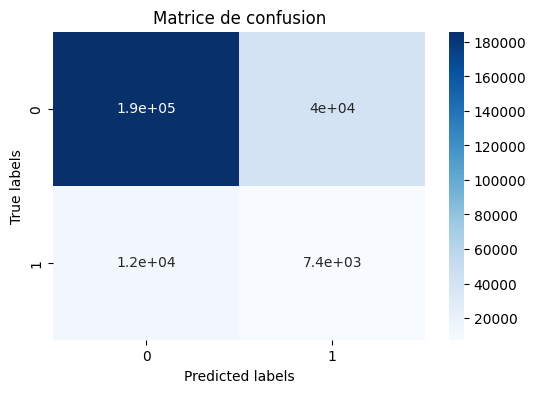

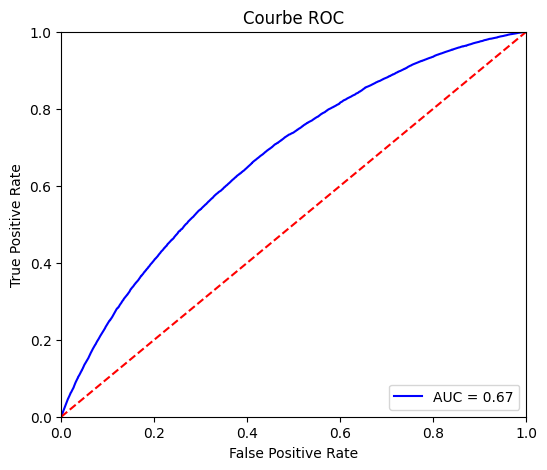

In [41]:
mlflow.set_experiment("LGBMClassifier")

from lightgbm import LGBMClassifier

# Création d'un scorer object à partir de votre fonction de score personnalisée
score_metier_scorer = make_scorer(fonction_metier, greater_is_better=True)

# Définition de la pipeline avec régression logistique
pipeline = Pipeline([
    ('smote', SMOTE(random_state=0)),
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(random_state=0))
])

# Paramètres pour RandomizedSearchCV
parameters =  {
    'classifier__n_estimators': [100, 200, 300],  # Nombre d'estimateurs
    'classifier__max_depth': [3, 4, 5],  # Profondeur maximale de chaque arbre
    'classifier__learning_rate': [0.1, 0.01, 0.001],  # Taux d'apprentissage
    'classifier__subsample': [0.8, 0.9, 1.0],  # Sous-échantillonnage de l'ensemble de données
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],  # Sous-échantillonnage des colonnes lors de la construction de chaque arbre
}

# Création du RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters, n_iter=20, cv=5, scoring=score_metier_scorer, random_state=0)

# Entraînement avec RandomizedSearchCV
with mlflow.start_run(run_name='LGBMClassifier avec SMOTE et StandardScaler'):
    random_search.fit(X_val, y_val)

    # Enregistrement des meilleurs paramètres et du meilleur score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    mlflow.log_params(best_params)
    mlflow.log_metric("best_score", best_score)

    # Calcul et enregistrement des métriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = eval_score(random_search.best_estimator_, X_val, y_val)

mlflow.log_metric("val_score_métier", score_metier)
mlflow.log_metric("val_accuracy", accuracy)
mlflow.log_metric("val_precision", precision)
mlflow.log_metric("val_recall", recall)
mlflow.log_metric("val_f1_score", f1_score)
mlflow.log_metric("val_fbeta_score", fbeta_score)
mlflow.log_metric("val_rocauc", rocauc)
    # Enregistrement du meilleur modèle
mlflow.lightgbm.log_model(random_search.best_estimator_, "best_model")


In [42]:
 best_params 

{'classifier__subsample': 1.0,
 'classifier__n_estimators': 100,
 'classifier__max_depth': 3,
 'classifier__learning_rate': 0.01,
 'classifier__colsample_bytree': 0.9}

Score métier maximum : 0.27
Threshold optimal : 0.44


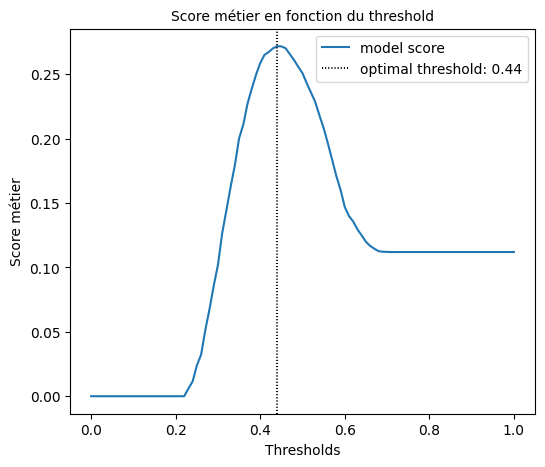

In [43]:
score_metier_max( y_pred_proba, y_val, verbose=True)

# essaie sur le test 

## XGBClassifier

In [122]:
# Terminer le run actif s'il y en a un
if mlflow.active_run():
    mlflow.end_run()


In [123]:
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

Score métier :0.24
Accuracy score : 0.70
Precision score : 0.13
Recall score : 0.48
F1 score : 0.20
Fbeta score : 0.31
ROC AUC score : 0.60


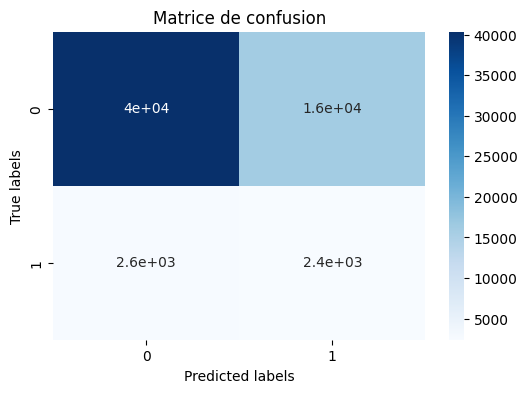

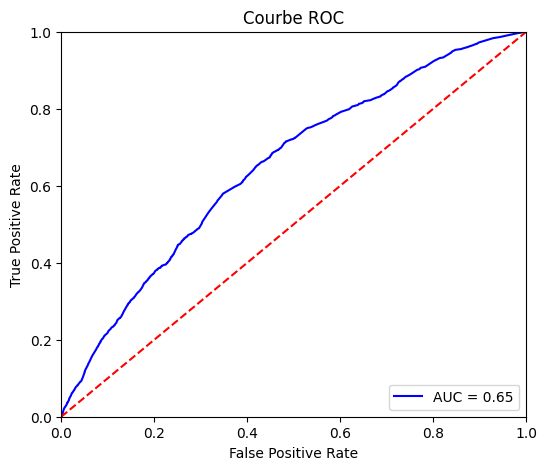

2024/04/29 10:27:08 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



In [11]:

from mlflow.tracking import MlflowClient
mlflow.set_experiment("XGBClassifier_test")

# Spécifiez l'ID de l'exécution correspondant à l'expérience souhaitée
run_id = "e9c35944a41e47adb15d35f2686bd316"

# Chargez le modèle associé à cette exécution
loaded_model_XGBC = mlflow.sklearn.load_model("runs:/" + run_id + "/best_model")

# Faites des prédictions sur le jeu de test
y_pred_test_proba = loaded_model_XGBC.predict_proba(X_val_test)[:, 1]
y_pred_test = np.where(y_pred_test_proba > 0.48, 1, 0)  # Appliquer le seuil optimal

# Calcul et enregistrement des métriques sur les données de validation
score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = eval_score(loaded_model_XGBC,X_val_test, y_val_test)

mlflow.log_metric("val_score_métier", score_metier)
mlflow.log_metric("val_accuracy", accuracy)
mlflow.log_metric("val_precision", precision)
mlflow.log_metric("val_recall", recall)
mlflow.log_metric("val_f1_score", f1_score)
mlflow.log_metric("val_fbeta_score", fbeta_score)
mlflow.log_metric("val_rocauc", rocauc)


## LGBMClassifier

In [67]:
# Terminer le run actif s'il y en a un
if mlflow.active_run():
    mlflow.end_run()


In [68]:
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

Score métier :0.25
Accuracy score : 0.79
Precision score : 0.16
Recall score : 0.38
F1 score : 0.22
Fbeta score : 0.29
ROC AUC score : 0.60


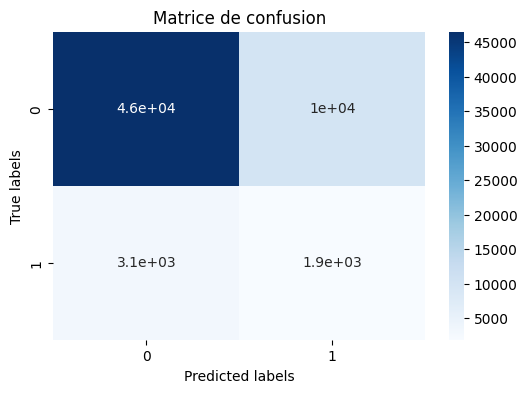

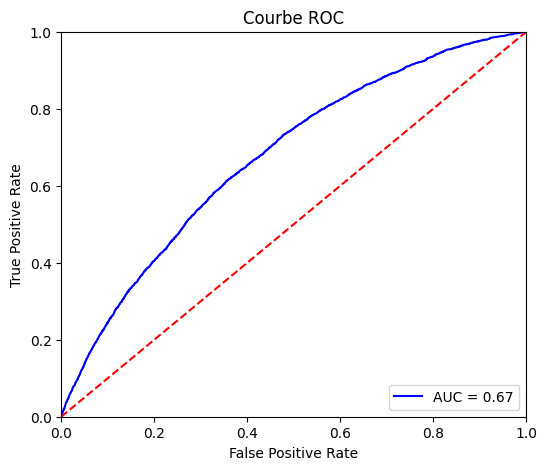

In [12]:
mlflow.set_experiment("LGBMClassifier_test")

# ID de l'exécution correspondant à l'expérience souhaitée
run_id = "51926dfcefa54c558f1cd9fe5cf40f86"

# le modèle associé à cette exécution
loaded_model_LGBMC = mlflow.lightgbm.load_model("runs:/" + run_id + "/best_model")

# prédictions sur le jeu de test
y_pred_test_proba = loaded_model_LGBMC.predict_proba(X_val_test)[:, 1]
y_pred_test = np.where(y_pred_test_proba > 0.44, 1, 0)  # Appliquer le seuil optimal

# Calcul et enregistrement des métriques sur les données de validation
score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = eval_score(loaded_model_LGBMC,X_val_test, y_val_test)

mlflow.log_metric("val_score_métier", score_metier)
mlflow.log_metric("val_accuracy", accuracy)
mlflow.log_metric("val_precision", precision)
mlflow.log_metric("val_recall", recall)
mlflow.log_metric("val_f1_score", f1_score)
mlflow.log_metric("val_fbeta_score", fbeta_score)
mlflow.log_metric("val_rocauc", rocauc)

# Amelioration model 

## TomekLinks

[LightGBM] [Info] Number of positive: 216445, number of negative: 216445
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24301
[LightGBM] [Info] Number of data points in the train set: 432890, number of used features: 177
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Score métier :0.27
Accuracy score : 0.75
Precision score : 0.15
Recall score : 0.45
F1 score : 0.23
Fbeta score : 0.32
ROC AUC score : 0.61


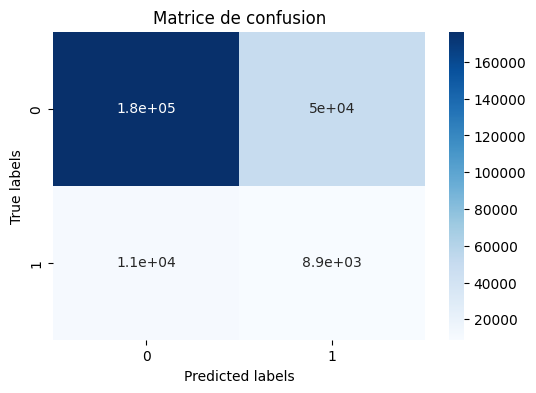

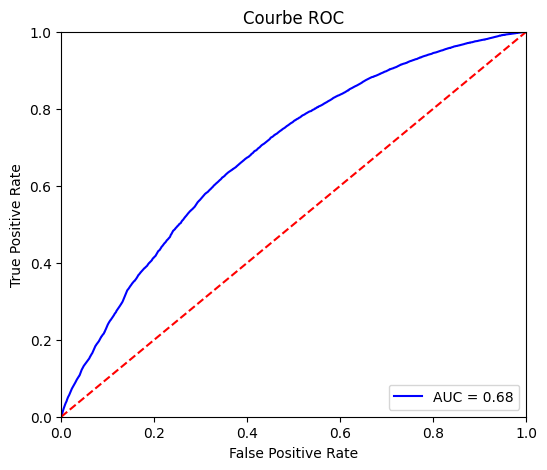

In [16]:
mlflow.set_experiment("LGBMClassifier_Tomek Links")
# ID de l'exécution correspondant à l'expérience souhaitée
run_id = "51926dfcefa54c558f1cd9fe5cf40f86"

# Charger le modèle associé à cette exécution
loaded_model_LGBMC = mlflow.lightgbm.load_model("runs:/" + run_id + "/best_model")

# une nouvelle pipeline avec une nouvelle méthode de gestion des données déséquilibrées
pipeline_new = Pipeline([
    ('new_sampling_method', TomekLinks()),  
    ('scaler', StandardScaler()),
    ('classifier', loaded_model_LGBMC)  # modèle chargé
])

# un nouveau run MLflow
with mlflow.start_run(run_name='LGBMClassifier avec Tomek Links et StandardScaler'):
    # Ajuster (fit) la nouvelle pipeline sur les données d'entraînement
    pipeline_new.fit(X_val, y_val)

    # Évaluer le modèle sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = eval_score(pipeline_new, X_val, y_val)
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)


## RandomUnderSampler

[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3072
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 160
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-th

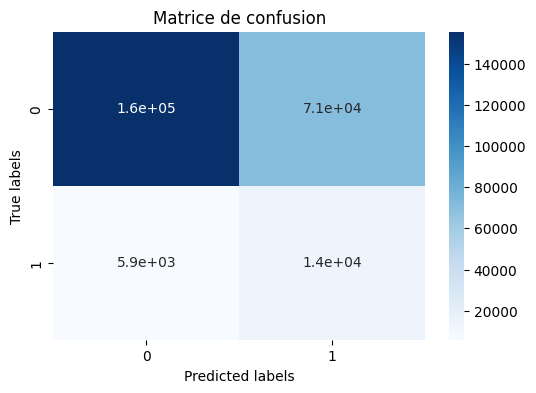

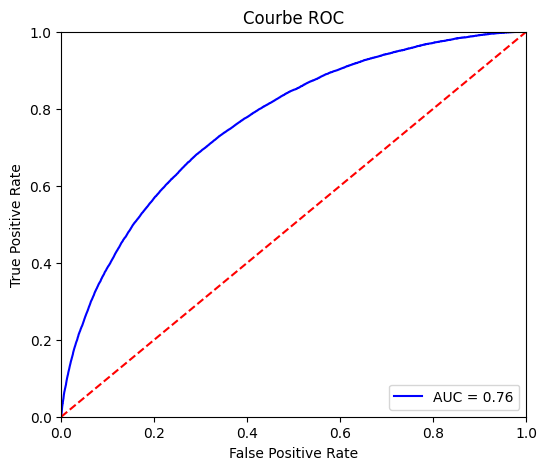

In [17]:
mlflow.set_experiment("LGBMClassifier_RandomUnderSampler_cv")
# Création d'un scorer object à partir de votre fonction de score personnalisée
score_metier_scorer = make_scorer(fonction_metier, greater_is_better=True)

# Définition de la pipeline avec régression logistique
pipeline = Pipeline([
    ('new_sampling_method', RandomUnderSampler()),  
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(random_state=0))  
])


# Paramètres pour RandomizedSearchCV
parameters =  {
    'classifier__n_estimators': [100, 200, 300],  # Nombre d'estimateurs
    'classifier__max_depth': [3, 4, 5],  # Profondeur maximale de chaque arbre
    'classifier__learning_rate': [0.1, 0.01, 0.001],  # Taux d'apprentissage
    'classifier__subsample': [0.8, 0.9, 1.0],  # Sous-échantillonnage de l'ensemble de données
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],  # Sous-échantillonnage des colonnes lors de la construction de chaque arbre
}

# Création du RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters, n_iter=20, cv=5, scoring=score_metier_scorer, random_state=0)

# Entraînement avec RandomizedSearchCV
with mlflow.start_run(run_name='LGBMClassifier_RandomUnderSampler_cv'):
    random_search.fit(X_val, y_val)

    # Enregistrement des meilleurs paramètres et du meilleur score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    mlflow.log_params(best_params)
    mlflow.log_metric("best_score", best_score)

    # Calcul et enregistrement des métriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = eval_score(random_search.best_estimator_, X_val, y_val)

mlflow.log_metric("val_score_métier", score_metier)
mlflow.log_metric("val_accuracy", accuracy)
mlflow.log_metric("val_precision", precision)
mlflow.log_metric("val_recall", recall)
mlflow.log_metric("val_f1_score", f1_score)
mlflow.log_metric("val_fbeta_score", fbeta_score)
mlflow.log_metric("val_rocauc", rocauc)
    # Enregistrement du meilleur modèle
mlflow.lightgbm.log_model(random_search.best_estimator_, "best_model")

## class_weights

[LightGBM] [Info] Number of positive: 15888, number of negative: 180916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 196804, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 180916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3134
[LightGBM] [Info] Number of data points in the train set: 196804, number of used features: 172
[LightGBM] [

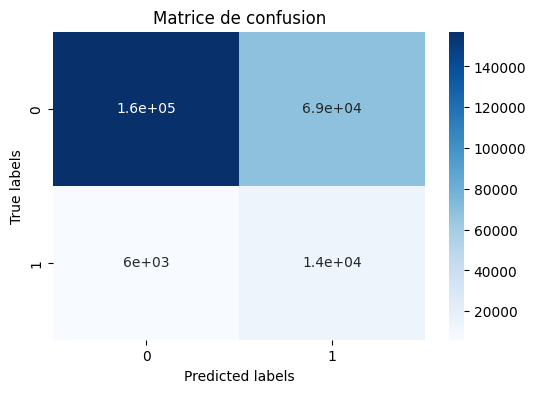

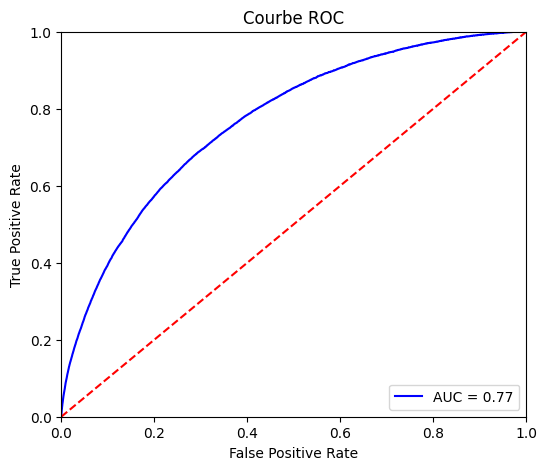

In [21]:
mlflow.set_experiment("LGBMClassifier_class_weight")

from lightgbm import LGBMClassifier

# Création d'un scorer object à partir dela fonction de score personnalisée
score_metier_scorer = make_scorer(fonction_metier, greater_is_better=True)

# Définition de la pipeline avec régression logistique
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(class_weight='balanced', random_state=0)) 
])

# Paramètres pour RandomizedSearchCV
parameters =  {
    'classifier__n_estimators': [100, 200, 300],  # Nombre d'estimateurs
    'classifier__max_depth': [3, 4, 5],  # Profondeur maximale de chaque arbre
    'classifier__learning_rate': [0.1, 0.01, 0.001],  # Taux d'apprentissage
    'classifier__subsample': [0.8, 0.9, 1.0],  # Sous-échantillonnage de l'ensemble de données
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],  # Sous-échantillonnage des colonnes lors de la construction de chaque arbre
}

# Création du RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters, n_iter=20, cv=5, scoring=score_metier_scorer, random_state=0)

# Entraînement avec RandomizedSearchCV
with mlflow.start_run(run_name='LGBMClassifier class_weight et StandardScaler'):
    random_search.fit(X_val, y_val)

    # Enregistrement des meilleurs paramètres et du meilleur score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    mlflow.log_params(best_params)
    mlflow.log_metric("best_score", best_score)

    # Calcul et enregistrement des métriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = eval_score(random_search.best_estimator_, X_val, y_val)

mlflow.log_metric("val_score_métier", score_metier)
mlflow.log_metric("val_accuracy", accuracy)
mlflow.log_metric("val_precision", precision)
mlflow.log_metric("val_recall", recall)
mlflow.log_metric("val_f1_score", f1_score)
mlflow.log_metric("val_fbeta_score", fbeta_score)
mlflow.log_metric("val_rocauc", rocauc)
    # Enregistrement du meilleur modèle
mlflow.lightgbm.log_model(random_search.best_estimator_, "best_model")

In [22]:
 best_params 

{'classifier__subsample': 1.0,
 'classifier__n_estimators': 300,
 'classifier__max_depth': 3,
 'classifier__learning_rate': 0.1,
 'classifier__colsample_bytree': 0.8}

Score métier maximum : 0.40
Threshold optimal : 0.52


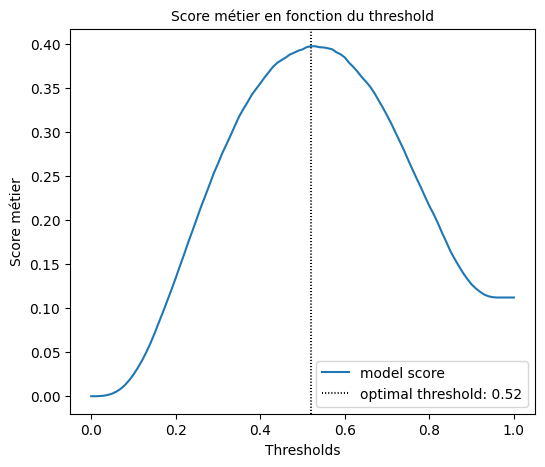

In [23]:
score_metier_max( y_pred_proba, y_val, verbose=True)

# essai du model ameliorer sur le test 

Score métier :0.39
Accuracy score : 0.69
Precision score : 0.17
Recall score : 0.69
F1 score : 0.27
Fbeta score : 0.42
ROC AUC score : 0.69


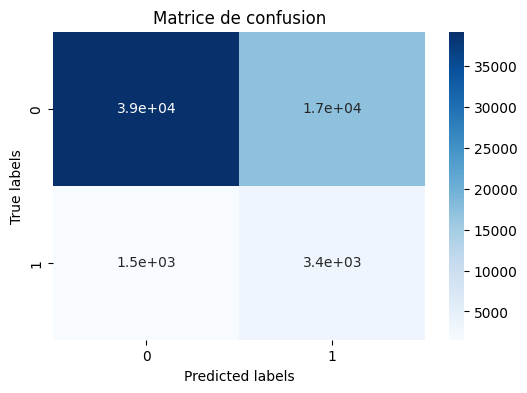

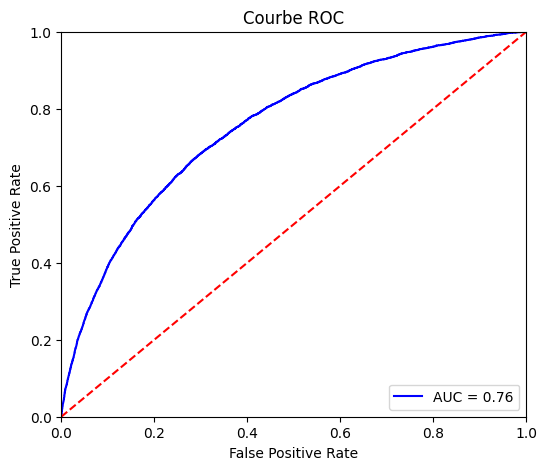

In [24]:
mlflow.set_experiment("LGBMClassifier_test_class_weight")

# l'ID de l'exécution correspondant à l'expérience souhaitée
run_id = "ea031936fe3d4c51b50154528e0e916a"

# le modèle associé à cette exécution
loaded_model_LGBMC = mlflow.lightgbm.load_model("runs:/" + run_id + "/best_model")

#prédictions sur le jeu de test
y_pred_test_proba = loaded_model_LGBMC.predict_proba(X_val_test)[:, 1]
y_pred_test = np.where(y_pred_test_proba > 0.52, 1, 0)  

# Calcul et enregistrement des métriques sur les données de validation
score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = eval_score(loaded_model_LGBMC,X_val_test, y_val_test)

mlflow.log_metric("val_score_métier", score_metier)
mlflow.log_metric("val_accuracy", accuracy)
mlflow.log_metric("val_precision", precision)
mlflow.log_metric("val_recall", recall)
mlflow.log_metric("val_f1_score", f1_score)
mlflow.log_metric("val_fbeta_score", fbeta_score)
mlflow.log_metric("val_rocauc", rocauc)

# shap 

##  feature importance globale 

In [25]:
# Extraire le modèle du pipeline
model = loaded_model_LGBMC.named_steps['classifier']

# Créer l'explainer SHAP avec le modèle extrait
explainer = shap.TreeExplainer(model)

# Calculer les valeurs SHAP pour les features
shap_values = explainer.shap_values(X_val_test)


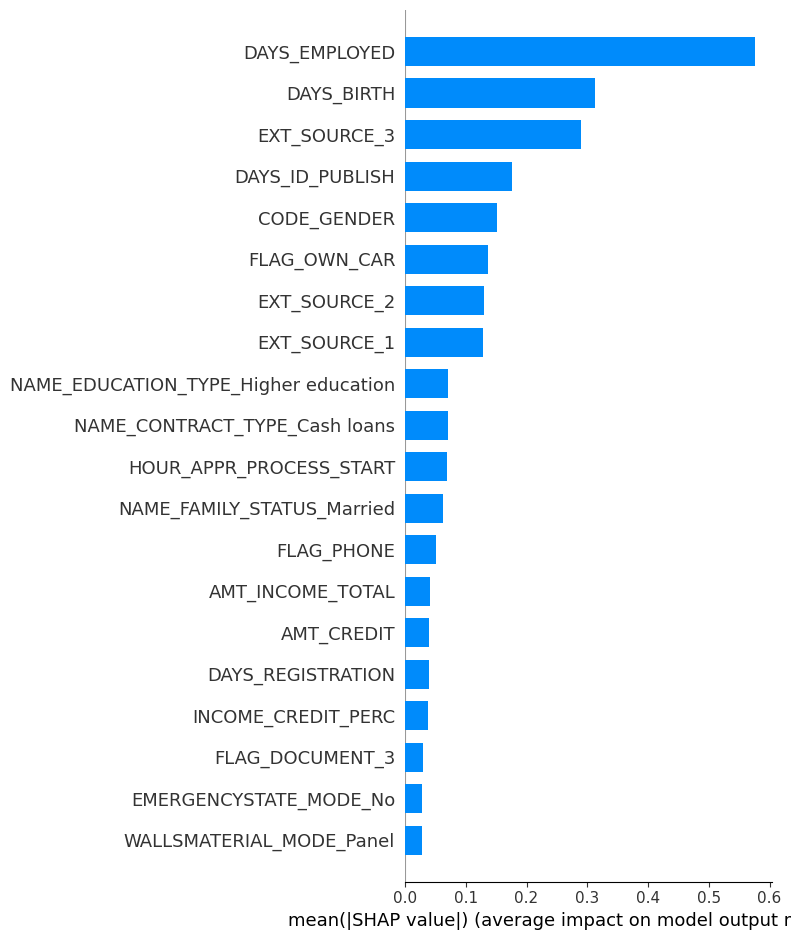

In [26]:
shap.summary_plot(shap_values, X_val_test, plot_type='bar')

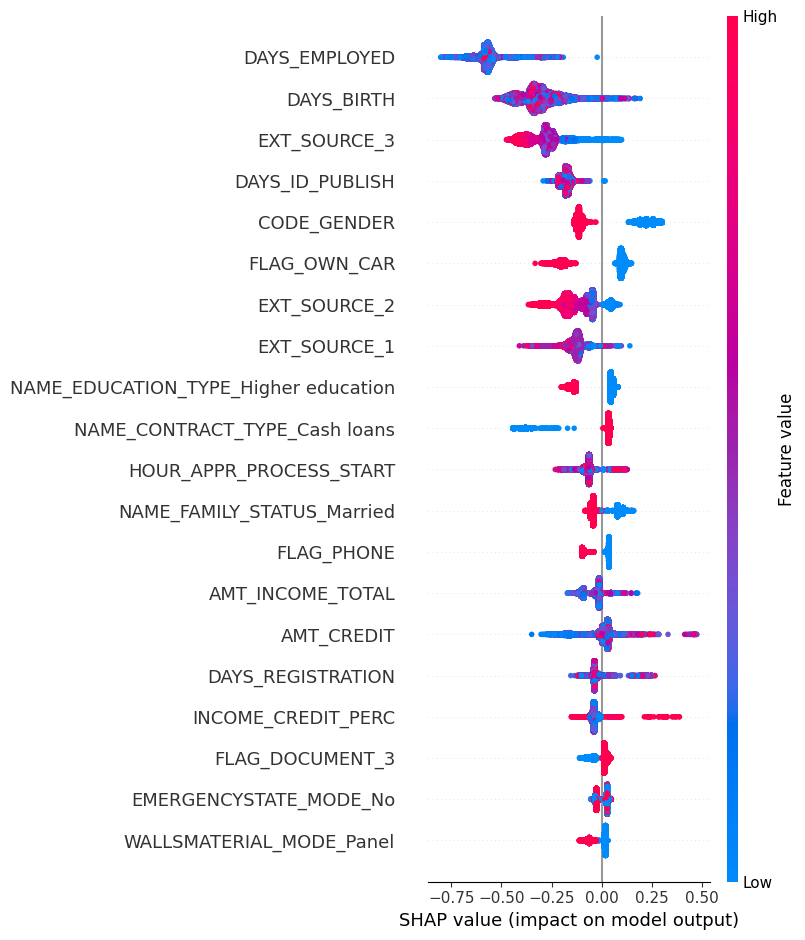

In [27]:
shap.summary_plot(shap_values, X_val_test, feature_names=X_val_test.columns)

##  feature importance locale 

In [28]:
i = 0
shap.initjs()
print("Individu ID: {}".format(X_val_test.index[i]))
shap.force_plot(explainer.expected_value,
                shap_values[i],
                X_val_test.values[i],
                feature_names=X_val_test.columns)


Individu ID: 210485


In [29]:
i = 2
shap.initjs()
print("Individu ID: {}".format(X_val_test.index[i]))
shap.force_plot(explainer.expected_value,
                shap_values[i],
                X_val_test.values[i],
                feature_names=X_val_test.columns)

Individu ID: 99346


# Dernier essai avec les features les plus importants

In [31]:

# Calculer les valeurs SHAP moyennes pour chaque feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Trier les features par leur importance SHAP moyenne
sorted_indices = np.argsort(mean_shap_values)[::-1]

# Sélectionner les 20 features les plus importantes
top_20_indices = sorted_indices[:20]

# Obtenir les noms des features correspondants
top_20_features = X_val_test.columns[top_20_indices]

# Afficher les noms des 20 features les plus importants
print("Les 20 caractéristiques les plus importantes :")
print(top_20_features)


Les 20 caractéristiques les plus importantes :
Index(['DAYS_EMPLOYED', 'DAYS_BIRTH', 'EXT_SOURCE_3', 'DAYS_ID_PUBLISH',
       'CODE_GENDER', 'FLAG_OWN_CAR', 'EXT_SOURCE_2', 'EXT_SOURCE_1',
       'NAME_EDUCATION_TYPE_Higher education', 'NAME_CONTRACT_TYPE_Cash loans',
       'HOUR_APPR_PROCESS_START', 'NAME_FAMILY_STATUS_Married', 'FLAG_PHONE',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_REGISTRATION',
       'INCOME_CREDIT_PERC', 'FLAG_DOCUMENT_3', 'EMERGENCYSTATE_MODE_No',
       'WALLSMATERIAL_MODE_Panel'],
      dtype='object')


In [34]:
colonne_a_garder = ['TARGET', 'SK_ID_CURR','DAYS_EMPLOYED', 'DAYS_BIRTH', 'EXT_SOURCE_3', 'DAYS_ID_PUBLISH',
       'CODE_GENDER', 'FLAG_OWN_CAR', 'EXT_SOURCE_2', 'EXT_SOURCE_1',
       'NAME_EDUCATION_TYPE_Higher education', 'NAME_CONTRACT_TYPE_Cash loans',
       'HOUR_APPR_PROCESS_START', 'NAME_FAMILY_STATUS_Married', 'FLAG_PHONE',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_REGISTRATION',
       'INCOME_CREDIT_PERC', 'FLAG_DOCUMENT_3', 'EMERGENCYSTATE_MODE_No',
       'WALLSMATERIAL_MODE_Panel']

# Sélectionner les colonnes spécifiées à partir de train_df
new_train_df = train_df.loc[:, colonne_a_garder]


In [35]:
new_train_df.head()

TARGET  SK_ID_CURR  DAYS_EMPLOYED  DAYS_BIRTH  EXT_SOURCE_3  \
0       1      100002          637.0   25.920548      0.139376   
1       0      100003         1188.0   45.931507      0.535276   
2       0      100004          225.0   52.180822      0.729567   
3       0      100006         3039.0   52.068493      0.535276   
4       0      100007         3038.0   54.608219      0.535276   

   DAYS_ID_PUBLISH  CODE_GENDER  FLAG_OWN_CAR  EXT_SOURCE_2  EXT_SOURCE_1  \
0           2120.0            0             0      0.262949      0.083037   
1            291.0            1             0      0.622246      0.311267   
2           2531.0            0             1      0.555912      0.505998   
3           2437.0            1             0      0.650442      0.505998   
4           3458.0            0             0      0.322738      0.505998   

   ...  HOUR_APPR_PROCESS_START  NAME_FAMILY_STATUS_Married  FLAG_PHONE  \
0  ...                       10                           0           1   
1  ...                       11                           1           1   
2  ...                        9                           0           1   
3  ...                       17                           0           0   
4  ...                       11                           0           0   

   AMT_INCOME_TOTAL  AMT_CREDIT  DAYS_REGISTRATION  INCOME_CREDIT_PERC  \
0          202500.0    406597.5             3648.0            0.498036   
1          270000.0   1293502.5             1186.0            0.208736   
2           67500.0    135000.0             4260.0            0.500000   
3          135000.0    312682.5             9833.0            0.431748   
4          121500.0    513000.0             4311.0            0.236842   

   FLAG_DOCUMENT_3  EMERGENCYSTATE_MODE_No  WALLSMATERIAL_MODE_Panel  
0                1                       1                         0  
1                1                       1                         0  
2                0                       0                         0  
3                1                       0                         0  
4                0                       0                         0  

[5 rows x 22 columns]

In [95]:
new_train_df.shape

(307507, 22)

In [116]:
# Supprimer les espaces dans les noms de colonnes
new_train_df.columns = new_train_df.columns.str.replace(' ', '')

new_train_df.columns

Index(['TARGET', 'SK_ID_CURR', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'EXT_SOURCE_3',
       'DAYS_ID_PUBLISH', 'CODE_GENDER', 'FLAG_OWN_CAR', 'EXT_SOURCE_2',
       'EXT_SOURCE_1', 'NAME_EDUCATION_TYPE_Highereducation',
       'NAME_CONTRACT_TYPE_Cashloans', 'HOUR_APPR_PROCESS_START',
       'NAME_FAMILY_STATUS_Married', 'FLAG_PHONE', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'DAYS_REGISTRATION', 'INCOME_CREDIT_PERC',
       'FLAG_DOCUMENT_3', 'EMERGENCYSTATE_MODE_No',
       'WALLSMATERIAL_MODE_Panel'],
      dtype='object')

In [119]:
 new_train_df2= new_train_df.drop(columns=['SK_ID_CURR'])


X2 = new_train_df2.drop(columns=['TARGET'])
y2 = new_train_df2['TARGET'].astype(int)

# Division du dataframe en ensembles d'entraînement et de validation


X_val2, X_val_test2, y_val2, y_val_test2 = train_test_split(X2, y2, test_size=0.20, stratify=y2, random_state=0)

print(X_val_test2.shape, y_val_test2.shape)
print(X_val2.shape, y_val2.shape)

(61502, 20) (61502,)
(246005, 20) (246005,)


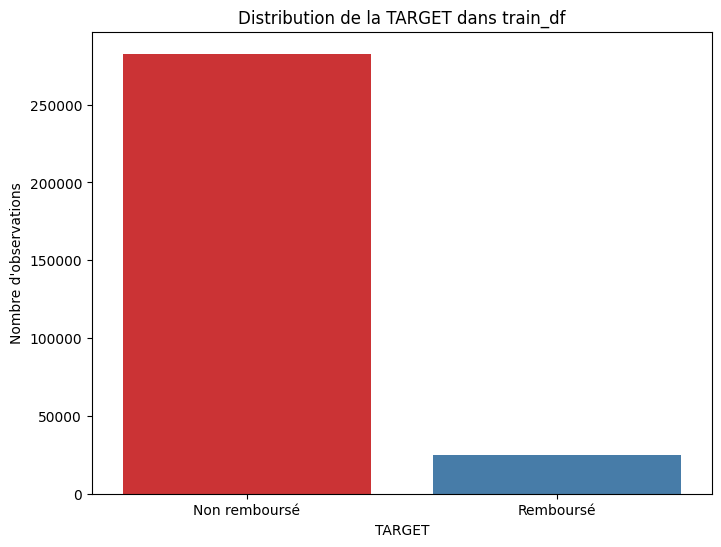

In [120]:
plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=new_train_df2, palette='Set1')
plt.xlabel('TARGET')
plt.ylabel('Nombre d\'observations')
plt.title('Distribution de la TARGET dans train_df')
plt.xticks([0, 1], ['Non remboursé', 'Remboursé'])
plt.show()


[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2593
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

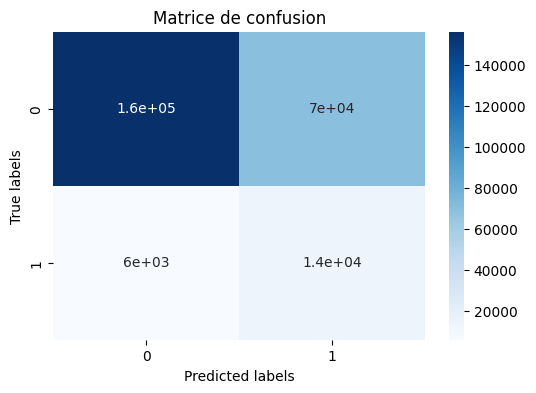

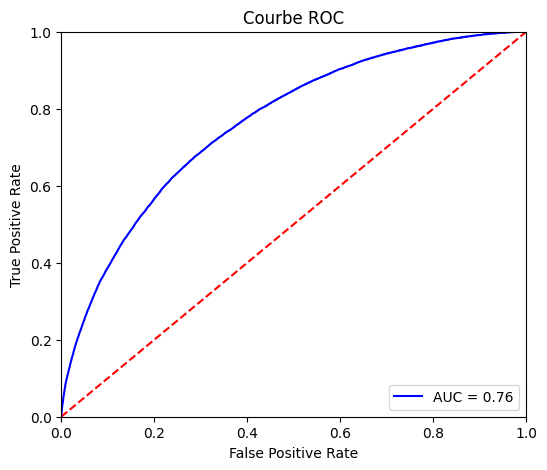

In [124]:
mlflow.set_experiment("LGBMClassifier_class_weight_20F")
# Création d'un scorer object à partir de votre fonction de score personnalisée
score_metier_scorer = make_scorer(fonction_metier, greater_is_better=True)

# Définition de la pipeline avec régression logistique
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(class_weight='balanced', random_state=0,
                                  n_estimators=300, max_depth=3, learning_rate=0.1,
                                  subsample=1.0,colsample_bytree=0.8))  
with mlflow.start_run(run_name='LGBMClassifier class_weight et StandardScaler_20F'):
    # Entraînement avec votre jeu de données
    pipeline.fit( X_val2, y_val2)

    # Évaluation sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = eval_score(pipeline, X_val2, y_val2)

    # Enregistrement des métriques
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

    # Enregistrement du modèle
    mlflow.lightgbm.log_model(pipeline, "best_model")


Score métier maximum : 0.39
Threshold optimal : 0.55


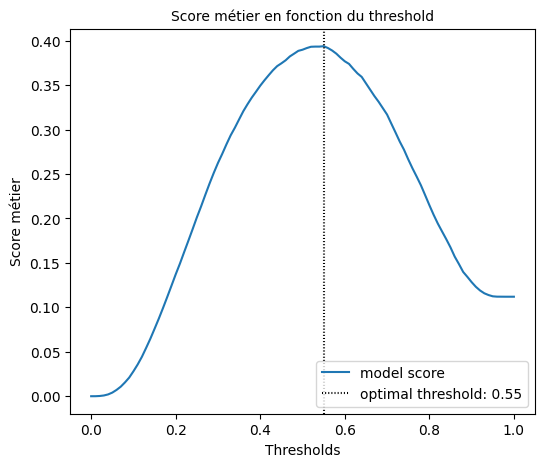

In [125]:
score_metier_max( y_pred_proba, y_val2, verbose=True)

## test 

Score métier :0.38
Accuracy score : 0.69
Precision score : 0.16
Recall score : 0.69
F1 score : 0.26
Fbeta score : 0.42
ROC AUC score : 0.69


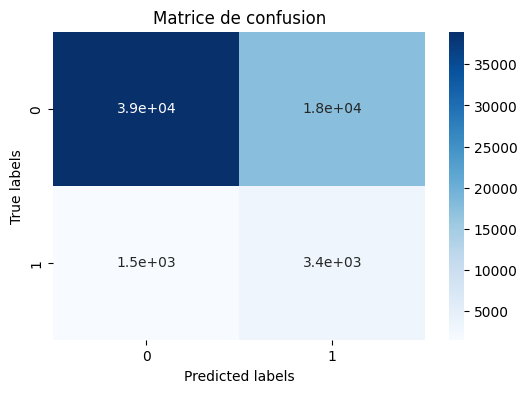

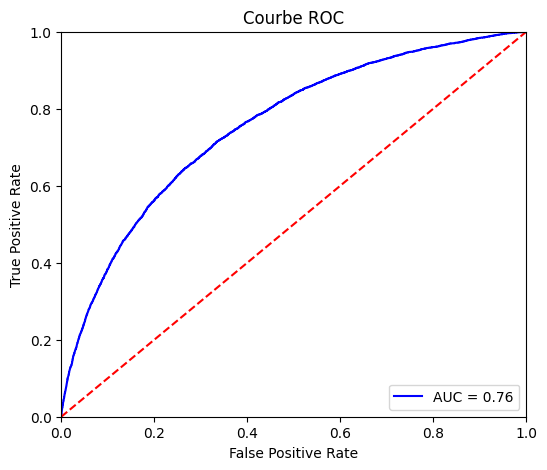

In [126]:

mlflow.set_experiment("LGBMClassifier_test_class_weight20F")

# ID de l'exécution correspondant à l'expérience souhaitée
run_id = "c808990109114f379d45ccb4e14b9ddc"

#le modèle associé à cette exécution
loaded_model_LGBMC2 = mlflow.lightgbm.load_model("runs:/" + run_id + "/best_model")
# prédictions sur le jeu de test
y_pred_test_proba2 = loaded_model_LGBMC2.predict_proba(X_val_test2)[:, 1]
y_pred_test2 = np.where(y_pred_test_proba2 > 0.55, 1, 0)  # Appliquer le seuil optimal

# Créer un DataFrame avec 'SK_ID_CURR' et les prédictions
predictions_df = pd.DataFrame({'SK_ID_CURR': X_val_test2.index, 'TARGET_PREDICTED': y_pred_test2})

# Calcul et enregistrement des métriques sur les données de validation
score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = eval_score(loaded_model_LGBMC2, X_val_test2, y_val_test2)

mlflow.log_metric("val_score_métier_test", score_metier)
mlflow.log_metric("val_accuracy_test", accuracy)
mlflow.log_metric("val_precision_test", precision)
mlflow.log_metric("val_recall_test", recall)
mlflow.log_metric("val_f1_score_test", f1_score)
mlflow.log_metric("val_fbeta_score_test", fbeta_score)
mlflow.log_metric("val_rocauc_test", rocauc)


# feature importance globale

In [127]:
# Extraire le modèle du pipeline
model2 = loaded_model_LGBMC2.named_steps['classifier']

# Créer l'explainer SHAP avec le modèle extrait
explainer2 = shap.TreeExplainer(model2)

# Calculer les valeurs SHAP pour les features
shap_values2 = explainer2.shap_values(X_val_test2)

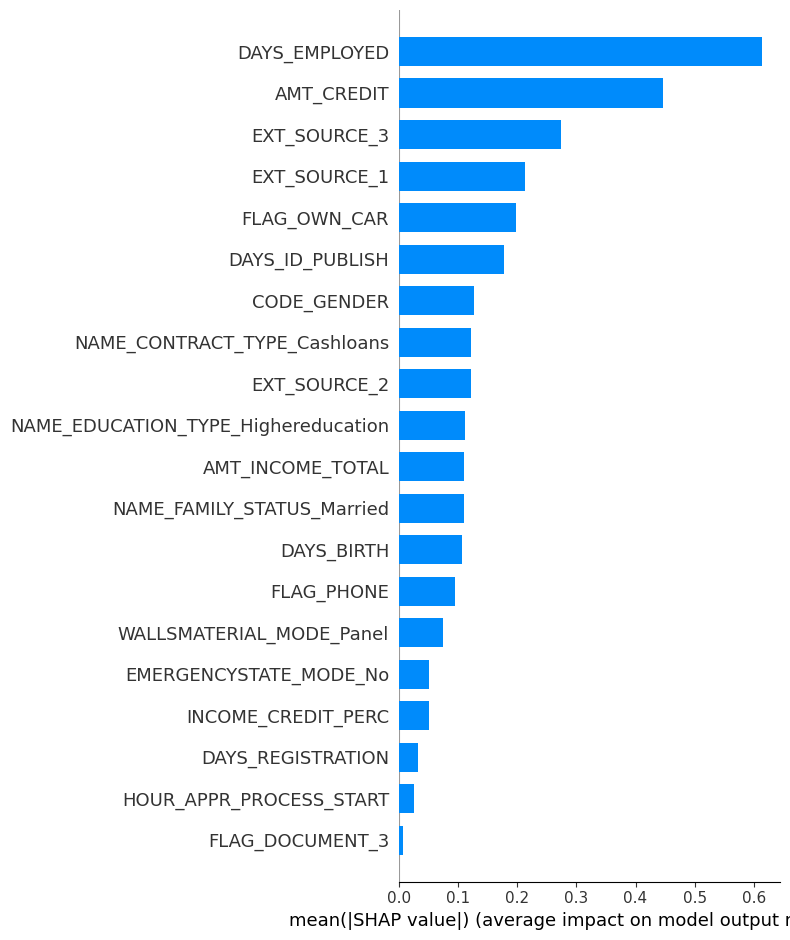

In [128]:
shap.summary_plot(shap_values2, X_val_test2, plot_type='bar')

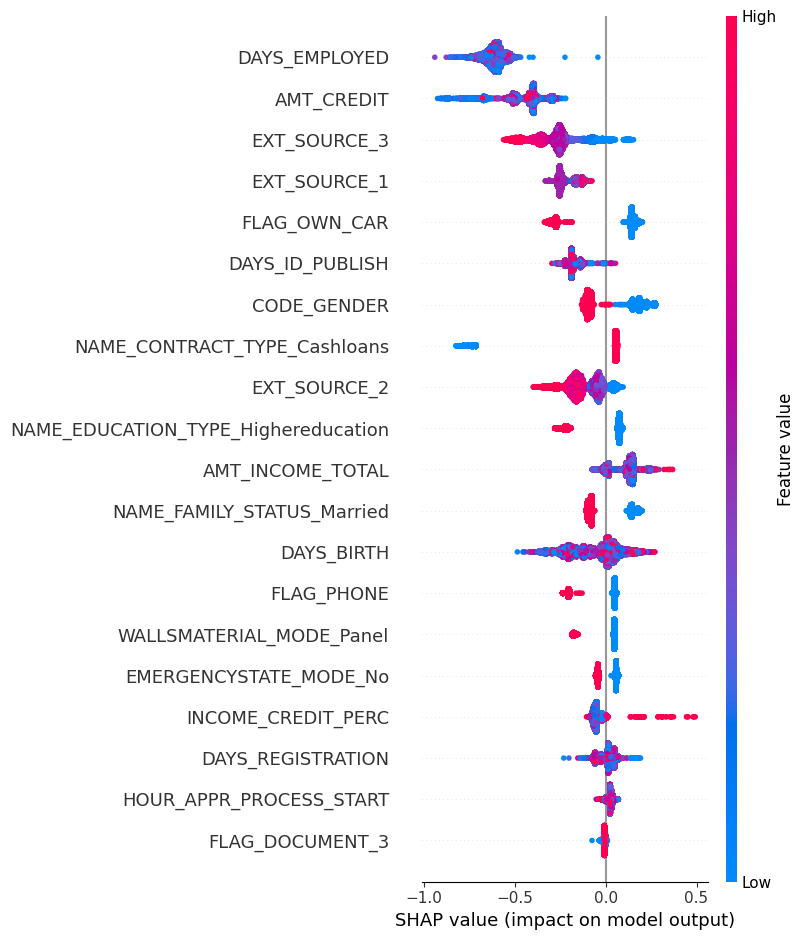

In [129]:
shap.summary_plot(shap_values2, X_val_test2, feature_names=X_val_test2.columns)

# feature importance locale

In [130]:
i = 0
shap.initjs()
print("Individu ID: {}".format(X_val_test2.index[i]))
shap.force_plot(explainer2.expected_value,
                shap_values2[i],
                X_val_test2.values[i],
                feature_names=X_val_test2.columns)

Individu ID: 210485


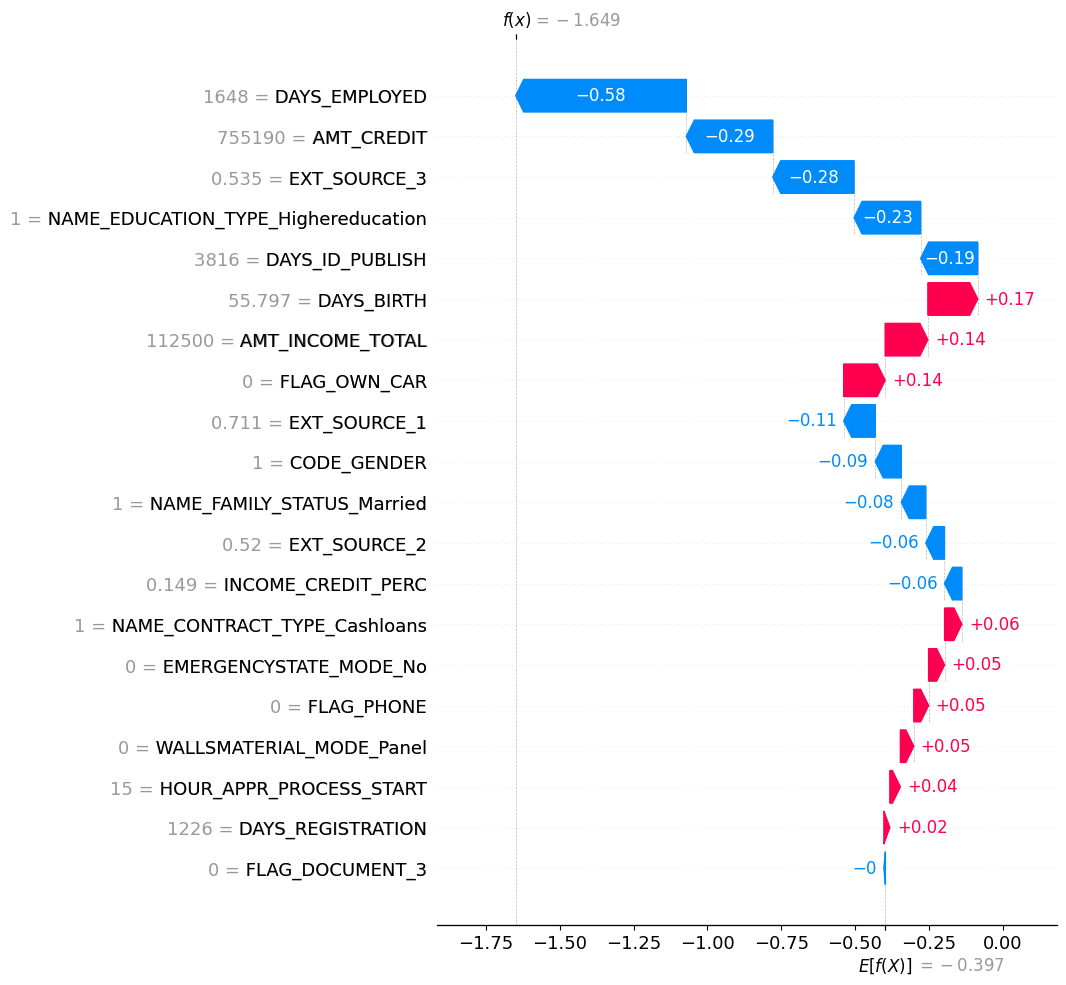

In [131]:
i=0
shap.waterfall_plot(shap.Explanation(values=shap_values2[i], base_values=explainer2.expected_value, data=X_val_test2.iloc[i]), max_display=20)


In [132]:
i = 2
shap.initjs()
print("Individu ID: {}".format(X_val_test2.index[i]))
shap.force_plot(explainer2.expected_value,
                shap_values2[i],
                X_val_test2.values[i],
                feature_names=X_val_test2.columns)

Individu ID: 99346


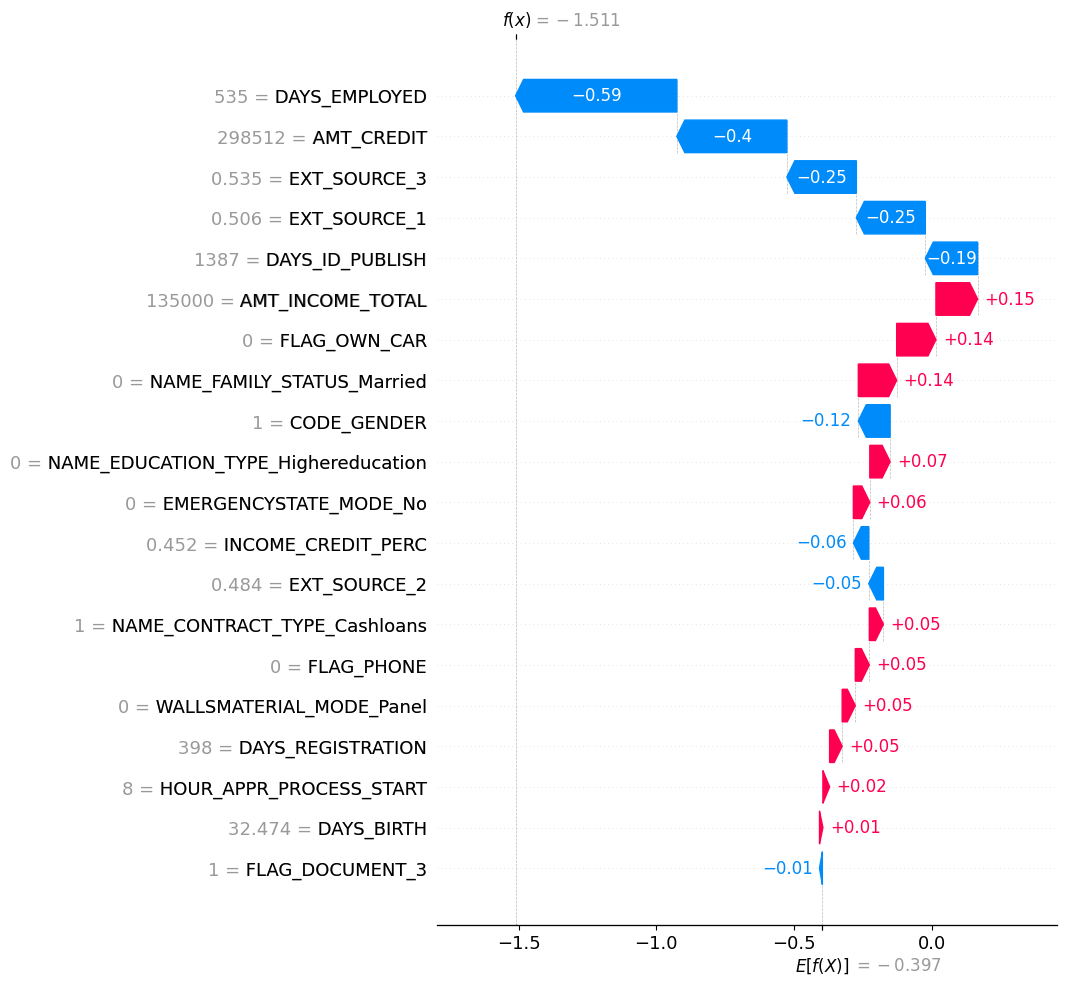

In [133]:
i=2
shap.waterfall_plot(shap.Explanation(values=shap_values2[i], base_values=explainer2.expected_value, data=X_val_test2.iloc[i]), max_display=20)



In [134]:
loaded_model_LGBMC2

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
                                max_depth=3, n_estimators=300,
                                random_state=0))])

In [135]:

run_id = "c808990109114f379d45ccb4e14b9ddc"

# Charger le modèle LightGBM
loaded_model_LGBMC2 = mlflow.lightgbm.load_model("runs:/" + run_id + "/best_model")

# Enregistrer le modèle LightGBM dans un fichier pickle
model_path = "C:\\Users\\imane\\Downloads\\data_science\\Projet7\\model.pickle"
mlflow.lightgbm.save_model(loaded_model_LGBMC2, model_path)


In [82]:
X_val_test2.to_csv('X_val_test2.csv', index = False)